In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
df = pd.read_csv(Path.home() / "Downloads/PA6_cleaned_dataset.csv")

## Pre Processing and Feature Engineering

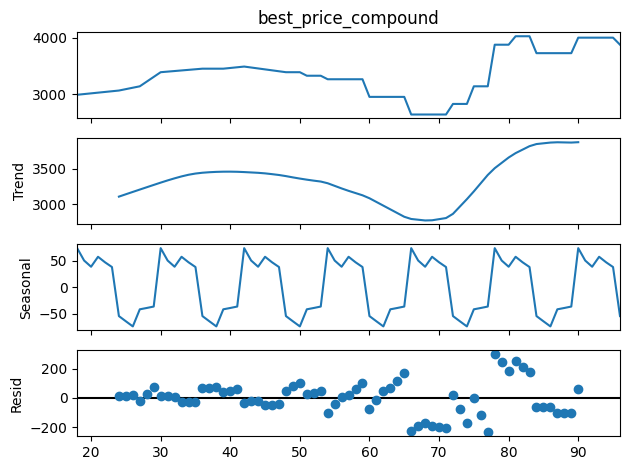

,time,PA6 GLOBAL_ EMEAS _ EUR per TON,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,...,quarter,year,best_price_compound_lag_1,rolling_mean,rolling_std,is_winter,is_summer,is_spring,is_autumn,best_price_compound_diff_1
18,2016-07-01,1525,44.126667,45.07,42.62,44.69,2.7879,4.674738,6.757119,60.655991,...,3,2016,NaN,NaN,NaN,0,1,0,0,NaN
19,2016-08-01,1550,44.876667,46.14,43.74,44.75,2.7913,4.047490,7.138675,57.973862,...,3,2016,2989.414608,NaN,NaN,0,1,0,0,NaN
20,2016-09-01,1550,45.043333,46.19,43.74,45.20,2.9689,4.253614,7.539793,61.382189,...,3,2016,3001.953566,3001.953566,12.538958,0,0,0,1,NaN
21,2016-10-01,1535,49.293333,49.73,48.26,49.89,2.9492,5.336819,7.652867,66.369097,...,4,2016,3014.492524,3014.492524,12.538958,0,0,0,1,NaN
22,2016-11-01,1535,45.260000,46.44,43.77,45.57,2.5009,5.693180,7.592589,62.578514,...,4,2016,3027.031482,3027.031482,12.538958,0,0,0,1,NaN


In [51]:
df['time'] = pd.to_datetime(df['time'])
df.dropna(subset="best_price_compound", inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(df['best_price_compound'], model='additive', period=12)  # Adjust period based on seasonality

# Plot the decomposed components
result.plot()
plt.show()

df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

# Encode date
df['month'] = pd.to_datetime(df['time']).dt.month
df['quarter'] = df['time'].dt.quarter
df['year'] = df['time'].dt.year

# Feature Engineering: Lagged Variables, as shown in CapGemini class
df['best_price_compound_lag_1'] = df['best_price_compound'].shift(1)  # Lag of 1 month

rolling_window = 3 
df['rolling_mean'] = df['best_price_compound'].rolling(window=rolling_window).mean()
df['rolling_std'] = df['best_price_compound'].rolling(window=rolling_window).std()

# Feature Engineering: Seasonal Indicators
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)

# Feature Engineering: Difference Features
df['best_price_compound_diff_1'] = df['best_price_compound'] - df['best_price_compound'].shift(12)  # Assuming monthly data

df.head(5)

## Hyperparameter thuning for Sarimax model

In [11]:
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm

df.set_index("time", inplace=True)
df.index.freq = 'MS'
train = df[df.index < '2022-01-01']
test = df[df.index >= '2022-01-01']

p_values = [1, 2]
d_values = [1]
q_values = [1, 2]
P_values = [1, 2]
D_values = [1]
Q_values = [1, 2]
s_values = [12]  

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_rmse = 0
best_params = None

# Iterate through all combinations
for params in tqdm(hyperparameter_combinations):
    p, d, q, P, D, Q, s = params

    # Fit SARIMA model
    sarima_model = SARIMAX(train['best_price_compound'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    sarima_result = sarima_model.fit()

    # Make predictions on the test set
    predictions = sarima_result.get_forecast(steps=len(test))
    predicted_values = predictions.predicted_mean

    rmse = sqrt(mean_squared_error(test['best_price_compound'], predicted_values))
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_rmse)


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\alexi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\alexi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\alexi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▋         | 1/

Best Hyperparameters: None
Best RMSE: 0


## Model training and testing

C:\Users\alexi\AppData\Local\Temp\ipykernel_22644\1749355248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train = train.drop("best_price_compound", axis=1, inplace=True)
C:\Users\alexi\AppData\Local\Temp\ipykernel_22644\1749355248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test = test.drop("best_price_compound", axis=1, inplace=True)
C:\Users\alexi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

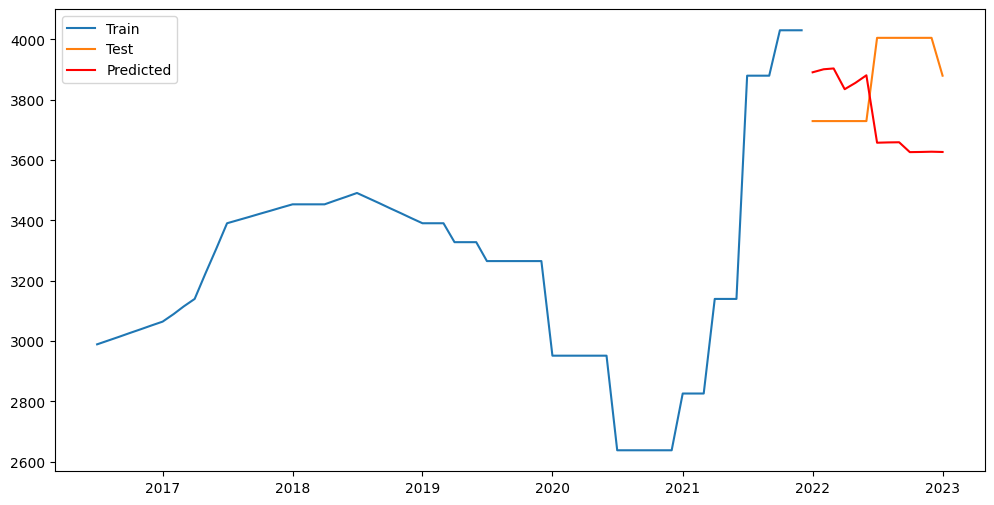

In [68]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df.set_index("time", inplace=True)
df.index.freq = 'MS'

train = df[df.index < '2022-01-01']
test = df[df.index >= '2022-01-01']
y_train = train["best_price_compound"]
y_test = test["best_price_compound"]
X_train = train.drop("best_price_compound", axis=1, inplace=True)
X_test = test.drop("best_price_compound", axis=1, inplace=True)

# Specify the order and seasonal_order based on your analysis
order = (1, 1, 1)  # Example order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Example seasonal_order (P, D, Q, s)

# Create and fit the SARIMAX model
sarimax_model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit()

# Make predictions on the test set
predictions = sarimax_result.get_forecast(steps=len(test), exog=X_test)
predicted_values = predictions.predicted_mean

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train.values, label='Train')
plt.plot(test.index, y_test.values, label='Test')
plt.plot(test.index, predicted_values, label='Predicted', color='red')
plt.legend()
plt.show()


### Not enough data for SARIMAX. With so few data, only tree models could be accurate (or adding external data)

### XGB Model

Split train/test

In [73]:
X = df.drop(["best_price_compound", "time"], axis=1).copy()
y = df["best_price_compound"].copy()

X_train = df.query("time < '2021-01-01'").drop(["time", "best_price_compound"], axis=1)
X_test = df.query("time >= '2021-01-01'").drop(["time", "best_price_compound"], axis=1)

y_train = df.query("time < '2021-01-01'")["best_price_compound"]
y_test = df.query("time >= '2021-01-01'")["best_price_compound"]

Randomized search for hyperparameter thuning

In [78]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Initialize an XGBoost model
model = XGBRegressor(random_state=42, n_jobs=-1)

# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.logspace(-5, 0, num=100),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
}

# Perform randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1
)

# Fit the randomized search model on the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = random_search.best_params_

Compare two different XGB: one trained on tscv, the other trained on standard xtrain and xtest (is hp tuning still relevant if model is trained on tscv ?)

In [83]:
#
model_tscv = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)

# Create a time series split iterator
tscv = TimeSeriesSplit(n_splits=5)

# Iterate through the splits and train the model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the XGBoost model on the training data
    model_tscv.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_ = model_tscv.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred_)
    print(f'Mean Squared Error during tscv: {mse}')

model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_tscv = model_tscv.predict(X_test)
mse_tscv = mean_squared_error(y_test, y_pred_tscv)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Squared Error on Test Set tcsv model: {mse_tscv}')

Mean Squared Error during tscv: 5555.752244937454
Mean Squared Error during tscv: 38942.48387119662
Mean Squared Error during tscv: 56452.10092933811
Mean Squared Error during tscv: 121577.02312411644
Mean Squared Error during tscv: 42438.160608338745
Best Hyperparameters: {'subsample': 0.8999999999999999, 'n_estimators': 550, 'max_depth': 5, 'learning_rate': 0.10974987654930568, 'colsample_bytree': 0.7999999999999999}
Mean Squared Error on Test Set: 42438.160608338745
Mean Squared Error on Test Set tcsv model: 42438.160608338745
